# High Frequency Trading - Avellaneda-Stoikov Model

---

## Introduction

Avellaneda & Stoikov (2006)'s paper *High-frequency trading in a limit order book* develops an **optimal (stock) market-making strategy** for HFT in a stochastic limit order book. A dealer dynamically posts bid/ask quotes to capture spreads while controlling inventory risk through continuous-time optimal stochastic control.

Traditional optimization frameworks address **two core risks**:

* **Inventory risk**: Uncertainty in the value of dealer holdings $q_t$. 
* **Asymmetric information risk** (adverse selection): Informed traders exploit stale quotes, capturing the economic spread while the dealer earns only microstructure edge.

The paper primarily tackles inventory risk optimization via a (asymptotically) tractable Hamilton-Jacobi-Bellman PDE, deriving inventory-aware reservation prices $r$ and optimal spreads that naturally mean-revert positions toward zero.

## Model Setup & Assumptions

### State Variables
$$
\mathbb{S} := (t, q_t, X_t, S_t)
$$ 
where:
* $t$ represents the current time
* $q_t$ represents the current inventory position
* $X_t$ represents the current cash incurred from the realised spreads
* $S_t$ is the mid-price of the stock

  
### Price Process
The stock mid-price follows pure Brownian motion: 

$$
dS_u = \sigma dW_u
$$

Over ultra-short HFT horizons (seconds to minutes), the drift $\mu \approx 0$ because the daily risk premium is dwarfed by volatility - trends and mean-reversion govern longer scales (hours+). 

This driftless diffusion is mathematically crucial: paired with CARA utility $u(x) = e^{-\gamma x}$, it enables a (asymptotically) tractable HJB PDE. 

Geometric Brownian motion $dS_u = \sigma S_u\,dW_u$ delivers equivalent short-horizon asymptotics but demands lognormal algebra which encounters issues with mathematical infinities; for simplicity we make no further mention of it here. Arithmetic Brownian motion $dS_u = \sigma\,dW_u$ streamlines derivations without much loss of generality. High-frequency empirical calibration (Avellaneda-Stoikov 2006; Gu\'eant 2016) confirms the approximation holds over 1-60s horizons.


### Orders
The agent quotes limit orders at distances $\delta^a, \delta^b > 0$ from their reference price. Intuitively, smaller $\delta$ means higher priority - your order sits closer to the best bid/ask and executes first against incoming market orders.

Consider a large market order of size $Q$. The top $Q$ best limit asks execute, with market impact defined as $\Delta p := p^Q - s$, where $p^Q$ is the most expensive (or deepest) ask price. In other words a limit ask at $p^a$ executes if $\delta^a < \Delta p$ - your quote must be "aggressive" enough to be reached by the aggressive market order.

Order arrivals are modeled as Poisson processes with intensities:
$$
\lambda^a(\delta^a), \quad \lambda^b(\delta^b)
$$

Intuitively, quotes further from the mid-price execute less frequently - far-away orders only fill against very aggressive market orders. Econophysics literature supports this: market order sizes follow a power law $f^Q(x) \propto x^{-1-\alpha}$ (large orders are rare), and impact satisfies $\Delta p \propto \ln(Q)$ (big orders walk the book deeper).

The intensity derives as:
$$
\begin{aligned}
\lambda(\delta) &= \Lambda \, P(\Delta p > \delta) \\
&= \Lambda \, P(\ln(Q) > K\delta) \\
&= \Lambda \, P(Q > e^{K\delta}) \\
&= \Lambda \int_{e^{K\delta}}^\infty x^{-1-\alpha} \, dx \\
&= A e^{-k\delta}
\end{aligned}
$$
where $A = \Lambda \alpha^{-1} K^\alpha$, $k = K\alpha$ are constants to calibrate.

### Wealth Process
Given the stochastic arrival of market orders, wealth evolves as a jump process:
$$
dX_t = \delta^a_t \, dN^a_t - \delta^b_t \, dN^b_t
$$
where $N^a_t$ counts ask fills (shares sold, cash inflow $\delta^a_t$) and $N^b_t$ counts bid fills (shares bought, cash outflow $\delta^b_t$). 


### Inventory Process
The inventory process follows:
$$
dq_t = dN^b_t - dN^a_t
$$
or equivalently $q_t = N^b_t - N^a_t$, where $N^b_t$ counts bid fills (shares bought) and $N^a_t$ counts ask fills (shares sold). 

Bid fills increase inventory (+1 share), ask fills decrease inventory (-1 share), creating the classic inventory risk $q_t \sigma \sqrt{T-t}$ that the market maker must hedge.

### Utility
CARA (Constant Absolute Risk Aversion) utility is given by $U(y) = -\exp(-\gamma y)$.

Economically, CARA utility captures constant absolute risk aversion - the market maker's utility penalizes dollar exposure risk, not percentage of total wealth. A HFT holding $q=1000$ shares faces inventory risk *irrespective* of if the HFT AUM is 1B USD or 1M USD. 

The $\gamma$ here is the absolute risk aversion coefficient where we can interpret it as "dollars of certain loss demanded per dollar of P&L variance".

Mathematically, it enables tractable solutions to the otherwise unsolvable 4D HJB equation. The value function separates as:
$$
U(t,x,q,s) = -\exp(-\gamma x) \cdot v(t,q,s)
$$
where $v(t,q,s)$ solves a simpler 3D PDE independent of absolute wealth $x$.

## Model Summary

$$
\begin{cases}
dX_t = \delta^a_t \, dN^a_t - \delta^b_t \, dN^b_t \\
dq_t = dN^b_t - dN^a_t \\
dS_t = \sigma S_t \, dW_t
\end{cases}
$$
where $N^{a,b}_t$ are independent Poisson processes with state-dependent intensities:
$$
\lambda^b_t = A e^{-k \delta^b_t}, \quad \lambda^a_t = A e^{-k \delta^a_t}
$$

We wish to maximise the agent utility given a set of optimal stochastic controls $\delta^a$ and $\delta^b$, i.e.
$$
U(t, x, q, s) = \sup_{\{\delta^a,\delta^b\} \in \mathcal{A}_{\{t, T\}}} \mathbb{E}^\delta \left[ -\exp\left(-\gamma (x_T + q_T s_T)\right) \right | \mathcal{F}_t]
$$
where $\mathbb{E}^\delta$ is the $\mathbb{P}$-expectation of the compensated $\delta$-Poisson process, and the admissible set of controls $\mathcal{A}_{\{t, T\}}$ as the $\delta^i: [t, T] \to \mathbb{R}$ such that:
$$
\begin{cases}
\delta^{i}_t(\cdot) &\geq 0 \\
0 \leq \delta^{i}_t(\cdot) &\leq \text{Exchange Limit} \\
\delta^{i} \, \text{is} \, \mathcal{F}_t \, \text{measurable} \\
\mathbb{E}[\int_t^T (\delta^{i}_s)^2 ] &< \infty
\end{cases}
$$

## CARA Utility under Frozen Inventory

In it's current form the CARA utility is a 4D function (with 3 stochastic dimensions). It will unlikely to be analytically untractable. We first consider an agent with "frozen inventory" to motivate the problem, where the agent holds their inventory of stocks (of size $q$) till terminal time $T$. This thus means $X_t = x$ and $q_t = q$.

We can now derive a closed form for the CARA utility under this assumption:

Given $S_T | S_t = s \sim \mathcal{N}(s, \sigma^2 \tau)$ where $\tau = T-t$, we derive the moment generating function $M_t(\theta) = \mathbb{E}[e^{\theta S_T} | S_t = s]$:
$$
M_t(\theta) = \int_{-\infty}^{\infty} e^{\theta z} \cdot \frac{1}{\sqrt{2\pi\sigma^2\tau}} \exp\left( -\frac{(z-s)^2}{2\sigma^2\tau} \right) dz
$$
Completing the square of the exponent:
$$
\begin{aligned}
\theta z - \frac{z^2 - 2sz + s^2}{2\sigma^2\tau} &= -\frac{1}{2\sigma^2\tau} \left[ z^2 - 2(s + \theta\sigma^2\tau)z \right] + \frac{s^2}{2\sigma^2\tau} \\
&= -\frac{(z - (s + \theta\sigma^2\tau))^2}{2\sigma^2\tau} + \underbrace{s\theta + \frac{1}{2}\theta^2\sigma^2\tau}_{\text{bonus term}}
\end{aligned}
$$
Recall the integral over the shifted Gaussian is 1, so:
$$
M_t(\theta) = \exp\left( s\theta + \frac{1}{2}\theta^2\sigma^2\tau \right)
$$
Plugging in the CARA condition $\theta = -\gamma q$ gives:
$$
U(t,x,q,s) = -\exp(-\gamma x) \exp(-\gamma q s) \exp\left( \frac{\gamma^2 q^2 \sigma^2}{2} (T-t) \right)
$$
In particular this form allows a clever guess of ansatz for a tractable HJB PDE.

## Definition: Indifference (Reservation) Prices

The central innovation of this paper is the combination of **indifference prices** with order book microstructure. We define them here, and refer to them later.

### Reservation Bid Price

The reservation bid $r^b(t,q,s)$ is the certain price making the dealer indifferent between:

1. Buying 1 share immediately at $r^b(t,q,s)$:
   $$
   U(t, x - r^b(t,q,s), q+1, s)
   $$

2. Continuing optimal market-making:
   $$
   U(t, x, q, s)
   $$

Which gives the indifference condition:
$$
U(t, x - r^b(t,q,s), q+1, s) = U(t, x, q, s)
$$

### Reservation Ask Price

Simiarly the reservation ask $$r^a(t,q,s)$$ equates utility between:

1. Selling 1 share immediately at $r^a(t,q,s)$:
   $$
   U(t, x + r^a(t,q,s), q-1, s)
   $$

2. Continuing optimal market-making:
   $$
   U(t, x, q, s)
   $$

Indifference condition is given by:
$$
U(t, x + r^a(t,q,s), q-1, s) = U(t, x, q, s)
$$

### Symmetric Indifference Price

The symmetric **indifference price** averages the reservations:
$$
r(t,q,s) = \frac{r^a + r^b}{2}
$$


## Derivation of the complete HJB PDE

We now move back to attempting to find a solution to the full utility maximisation of the 4D utility function:
$$
U(t,x,q,s) = \sup_{\{\delta^a,\delta^b\} \in \mathcal{A}_{\{t, T\}}} \mathbb{E}^\delta \left[ -\exp\left(-\gamma (X_T + q_T S_T)\right) \right | \mathcal{F}_t]
$$

This involves the derivation of the HJB equation. To do this, we apply the dynamic programming principle (DPP): the value in state $(t,x,q,s)$ equals the best immediate action plus guaranteed optimal play from the next state. By the DPP:
$$
U(t, x, q, s) = \sup_{\{\delta^a,\delta^b\} \in \mathcal{A}_{\{t, t + h\}}} \mathbb{E}^\delta \Big[ U(t+h, X^\delta_{t+h}, q^\delta_{t+h}, S_{t+h}) \Big| \mathcal{F}_t \Big]
$$

By the jump-diffusion Itô formula:
$$
dU(t, x, q, s) = \left( U_t + \frac{1}{2} \sigma^2 s_t^2 U_{ss} \right) dt + \sigma s_t U_s \, dW_t 
+ \left[ U(x + \delta^b - s, q_t + 1, s) - U \right] dN^b_t 
+ \left[ U(x + \delta^a - s, q_t - 1, s) - U \right] dN^a_t
$$

Decompose the Poisson processes via their martingale representations:
$$
dN^i_t = d\tilde{N}^i_t + \lambda^i(\delta^i_t) \, dt, \quad i \in \{a,b\}
$$
and we have
$$
dU = \mathcal{L}^\delta U \, dt + \sigma s U_s \, dW_t + \big[U(x - s + \delta^b, q - 1, s) - U\big] d\tilde{N}^b_t + \big[U(x + s + \delta^a, q + 1, s) - U\big] d\tilde{N}^a_t
$$
where the full generator is given by:
$$
\mathcal{L}^\delta = \left( U_t + \frac{1}{2} \sigma^2 s_t^2 U_{ss} \right) + \lambda^b_t \big[U(X_t - s + \delta^b_t, q_t + 1, s_t) - U\big] + \lambda^a_t \big[U(X_t + s + \delta^a_t, q_t - 1, s_t) - U\big]
$$

Integrate over $[t,t+h]$ and take $\mathbb{E}^\delta[\cdot | \mathcal{F}_t]$. These martingale terms vanish:
$$
\mathbb{E}^\delta \left[\int_t^{t+h} \sigma s U_s \, dW_{\tilde{t}} \,\Big|\, \mathcal{F}_t \right] = 0, \quad 
\mathbb{E}^\delta \left[\int_t^{t+h} [U(\pm) - U] d\tilde{N}^i_{\tilde{t}} \,\Big|\, \mathcal{F}_t \right] = 0
$$
and we are left with:
$$
\begin{aligned}
\mathbb{E}^\delta \Big[ U(t+h, \cdot) \Big| \mathcal{F}_t \Big] &= U + \mathbb{E}^\delta \Big[ \int_t^{t+h} \mathcal{L}^\delta U(\tilde{t}, \cdot) \, d\tilde{t} \Big| \mathcal{F}_t \Big] \\
\mathbb{E}^\delta \Big[ U(t+h,\cdot) - U \Big| \mathcal{F}_t \Big] &= \mathbb{E}^\delta \Big[ \int_t^{t+h} \mathcal{L}^\delta U(\tilde{t}, \cdot) \, d\tilde{t} \Big| \mathcal{F}_t \Big] 
\end{aligned}
$$

Divide by $h$:
$$
\frac{\mathbb{E}^\delta \Big[ U(t+h,\cdot) - U \Big| \mathcal{F}_t \Big]}{h} = \frac{1}{h} \mathbb{E}^\delta \Big[ \int_t^{t+h} \mathcal{L}^\delta U(\tilde{t}, \cdot) \, d\tilde{t} \Big| \mathcal{F}_t \Big]
$$

Reintroducing the DPP gives HJB as $h \to 0$, where the dominated convergence theorem is used exchange the limit and expectation for the RHS:
$$
\begin{aligned}
0 &= \sup_{\{\delta^a,\delta^b\} \in \mathcal{A}_{\{t, T\}}} \mathcal{L}^\delta U \\
&= U_t + \frac{1}{2} \sigma^2 s^2 U_{ss} + \sup_{\{\delta^a,\delta^b\} \in \mathcal{A}_{\{t, T\}}}  \Big\{ \lambda^b(\delta^b) \big[ U(t, x - s + \delta^b, q+1, s) - U \big] + \lambda^a(\delta^a) \big[ U(t, x + s + \delta^a, q-1, s) - U\big] \Big\}
\end{aligned}
$$

With terminal condition
$$
U(T,x,q,s) = -\exp(-\gamma(x + q s))
$$

## Simplification via Ansatz

Motivated by the frozen inventory certainty equivalent, we adopt the CARA ansatz, i.e. separating out the realised cash:
$$
U(t,x,q,s) = -\exp\left( -\gamma \left[ x + \theta(t,q,s) \right] \right)
$$

We have via the chain rule:
$$
\begin{cases}
\partial_t U = \gamma \partial_t \theta \, U \\
U_s = \gamma \theta_s U \\
U_{ss} = \gamma \theta_{ss} U + \gamma \theta_s (\gamma \theta_s U) = \gamma \theta_{ss} U + \gamma^2 \theta_s^2 U

\end{cases}
$$

And:
$$
\begin{cases}
U(t, x - s + \delta^a, q-1, s) - U = U(t,x,q,s) \left[ \exp\left( \gamma ( -s + \delta^a ) + \gamma \left[ \theta(t,q-1,s) - \theta(t,q,s) \right] \right) - 1 \right] \\
U(t, x + s + \delta^b, q+1, s) - U = U(t,x,q,s) \left[ \exp\left( \gamma (s + \delta^b) + \gamma \left[ \theta(t,q+1,s) - \theta(t,q,s) \right] \right) - 1 \right]
\end{cases}
$$

Substituting back into the the HJB and dividing by $U$, in particular recalling that $u < 0$ as $\exp(\cdot) > 0$:
$$
0 = \partial_t \theta + \frac{1}{2} \sigma^2 \partial_{ss} \theta + \frac{1}{2} \gamma \sigma^2 \theta_s^2 
+ \sup_{\delta^a,\delta^b \geq 0} \Big\{ 
\lambda^a(\delta^a) \left[ \exp\left( \gamma (s + \delta^a) + \gamma \left[ \theta(t,q-1,s) - \theta(t,q,s) \right] \right) - 1 \right]
+ 
\lambda^b(\delta^b) \left[ \exp\left( \gamma (s - \delta^b) + \gamma \left[ \theta(t,q+1,s) - \theta(t,q,s) \right] \right) - 1 \right]
\Big\}
$$

Now recall the reservation bid price is defined by
$$
U(t, x, q, s) = U(t, x - r^b, q+1, s)
$$

Similarly substituting the ansatz:
$$
\begin{aligned}
-\exp(-\gamma x) \exp(-\gamma \theta(t,s,q)) &= -\exp(-\gamma (x - r^b)) \exp(-\gamma \theta(t,s,q+1)) \\
r^b(t,s,q) &= \theta(t,s,q+1) - \theta(t,s,q)
\end{aligned}
$$

A similar argument gives the reservation ask price:
$$
\begin{aligned}
r^a(t,s,q) &= \theta(t,s,q) - \theta(t,s,q-1)
\end{aligned}
$$

Which further reduces the HJB PDE nicely to:
$$
\begin{cases}
0 = \partial_t \theta + \frac{1}{2} \sigma^2 \partial_{ss} \theta - \frac{1}{2} \gamma \sigma^2 \theta_s^2 
+ \sup_{\delta^a,\delta^b \geq 0} \Big\{ 
\lambda^a(\delta^a) \left[ \exp\big(\gamma (s + \delta^a - r^a)\big) - 1 \right] + 
\lambda^b(\delta^b) \left[ \exp\big(\gamma (s - \delta^b - r^b)\big) - 1 \right]
\Big\} \\
\theta(s, q, T) = qs 
\end{cases}
$$


## Asymptotic Expansion in Inventory

After substituting optimal $\delta^a_*, \delta^b_*$ and assuming symmetric exponential arrival rates:

$$\lambda^a(\delta) = \lambda^b(\delta) = A e^{-k\delta}$$

We obtain:
$$
\begin{cases}
\partial_t \theta + \frac{1}{2} \sigma^2 \theta_{ss} - \frac{1}{2} \sigma^2 \gamma \theta_s^2 + \frac{A}{k+\gamma} \left( e^{-k\delta^a_*} + e^{-k\delta^b_*} \right) = 0 \\
\theta(s,q,T) = q s
\end{cases} 
$$

The HJB PDE remains analytically intractable in full generality. The authors propose an asymptotic Taylor expansion of the reduced value function $\theta(t,q,s)$ around zero inventory:
$$
\theta(t,q,s) = \theta^0(t,s) + q\,\theta^1(t,s) + \frac{1}{2}q^2\,\theta^2(t,s) + O(q^3)
$$

Economically, this again reflects inventory risk control: market makers target $q \approx 0$ to minimize directional exposure $q\sigma\sqrt{T-t}$. Higher-order terms capture inventory aversion - $\theta^2 < 0$ penalizes large $|q|$ positions. The approximation converges rapidly since HFT positions remain small relative to typical volatility horizons.

Recall the bid reservation price is given by:
$$
r^b(t,s,q) = \theta(t,s,q+1) - \theta(t,s,q)
$$

We can expand the difference:
$$
\begin{aligned}
\theta(t,s,q+1) &= \theta^0 + (q+1)\theta^1 + \frac{1}{2}(q+1)^2\theta^2 + \cdots \\
&= \theta^0 + (q + 1)\theta^1 + \frac{1}{2}(q^2 + 2q + 1)\theta^2 + \cdots 
\end{aligned}
$$
and now subtracting to get:
$$
\begin{aligned}
r^b &= [\theta^0 + q\theta^1 - \theta^1 + \frac{1}{2}(q^2 + 2q + 1)\theta^2] - [\theta^0 + q\theta^1 + \frac{1}{2}q^2\theta^2] + \cdots \\
&= \theta^1 + q\theta^2 + \frac{1}{2}\theta^2 + \cdots \\
&= \theta^1 + (q + \frac{1}{2})\theta^2 + \cdots
\end{aligned}
$$

A similar argment gives us the ask price as well
$$
\begin{cases}
r^a(t,s,q) = \theta^1(s,t) + \left(\frac{1}{2} - q\right)\theta^2(s,t) + \cdots \\
r^b(t,s,q) = \theta^1(s,t) + \left(q + \frac{1}{2}\right)\theta^2(s,t) + \cdots
\end{cases}
$$

Now we can simply match orders of the PDEs in $q$ to find the $\theta$ coefficients:

$O(q)$ terms:
$$
\begin{cases}
\theta^1_t + \frac{1}{2} \sigma^2 \theta^1_{ss} = 0 \\
\theta^1(s, T) = s
\end{cases}
$$

Solution: 
$$\boxed{\theta^1(s,t) = s}$$

$O(q^2)$ terms:
$$
\begin{cases}
\theta^2_t + \frac{1}{2} \sigma^2 \theta^2_{ss} - \frac{1}{2} \sigma^2 \gamma (\theta^1_s)^2 = 0 \\
\theta^2(s, T) = 0
\end{cases}
$$

**Since $\theta^1_s = 1$** this simplifies to:
$$
\boxed{\theta^2_t - \frac{1}{2} \sigma^2 \gamma = 0 \quad \to \quad \theta^2 = \frac{1}{2} \gamma \sigma^2 (T-t)}
$$

And we are finally to obtain an approximation to the solution of $\theta$.

## Reservation Price

From the asymptotic expansion, the reservation bid/ask price is 
$$
\begin{cases}
r^a(t,s,q) = \theta^1(s,t) + \left(\frac{1}{2} - q\right)\theta^2(s,t) + \cdots \\
r^b(t,s,q) = \theta^1(s,t) + \left(q + \frac{1}{2}\right)\theta^2(s,t) + \cdots
\end{cases}
$$

Thus the symmetric reservation price is:
$$
r(t, s, q) = \frac{r^a + r^b}{2} =  s - \frac{1}{2} q \gamma \sigma^2 (T-t) + \cdots
$$

Positive inventory $q > 0$ exposes the market maker to adverse selection risk: the mid-price $s_t$ may decline before liquidation. Quotes therefore skew downward ($r(t,q) < s$) to encourage ask fills and reduce $q$. For negative inventory $q < 0$, quotes skew upward to encourage bid fills. The term $\frac{1}{2} \gamma \sigma^2 (T-t)$ quantifies this risk. This makes $r(t,q)$ the natural **indifference/reservation price** around which to center the limit order spread.

##  Optimal Controls

We can find optimal $\delta^a$ and $\delta^b$ via the first order conditions. First take the bid side:
$$
\begin{aligned}
0 &= \frac{\partial\mathcal{L}^\delta U}{\partial\delta^b}  \\
&= \frac{\partial \lambda^b}{\partial\delta^b}(\delta^b_*)[e^{\gamma(s-\delta^b_*-r^b)}-1] - \gamma\lambda^b(\delta^b_*)e^{\gamma(s-\delta^b_*-r^b)}
\end{aligned}
$$
Take logs and rearrange and we have:
$$
s - r^b = \delta^b_* - \frac{1}{\gamma}\ln\left(1 - \frac{\gamma\lambda^b(\delta^b_*)}{\lambda^{b\prime}(\delta^b_*)}\right)
$$

Now recall the assumption of 
$$\lambda^a(\delta) = \lambda^b(\delta) = A e^{-k\delta}$$
and we obtain
$$
\boxed{s - r^b = \delta^b_* + \frac{1}{\gamma} \ln\left(1 + \frac{\gamma}{k}\right)}
$$

On the ask side, a similar argument gives:
$$
\boxed{r^a - s = \delta^a_* + \frac{1}{\gamma} \ln\left(1 + \frac{\gamma}{k}\right)}
$$

Which now gives the optimal bid and ask spread explicitly.

# Summary

Assuming symmetric optimal spreads $\delta^a_* = \delta^b_* = \delta^*(t)$ (standard in literature), quotes center around the reservation price, given by:
$$
\boxed{
\begin{aligned}
p^b &= r(t, s, q) - \delta^*(t) \\
p^a &= r(t, s, q) + \delta^*(t)
\end{aligned}
}
$$

The reservation price is given by:
$$
\boxed{r(t, s, q) = s - \frac{1}{2}q \gamma \sigma^2 (T-t)}
$$

and the symmetric spread is derived from the reservation bid/ask price: 
$$
\boxed{\delta^*(t) = \frac{\gamma \sigma^2 (T-t)}{2} + \frac{1}{\gamma} \ln\left(1 + \frac{\gamma}{k}\right)}
$$

## Implementation

In [1]:
import logging
import timeit
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
from importnb import Notebook
from numba import njit

with Notebook():
    pass

In [2]:
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
if not log.hasHandlers():
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter("[%(asctime)s] [%(levelname)s] %(message)s"))
    log.addHandler(handler)

In [3]:
@njit(error_model="numpy")
def price_path(S0: float, sigma: float, dt: float, n_steps: int) -> np.ndarray:
    """Arithmetic BM price path."""
    sqrt_dt = np.sqrt(dt)
    S_path = np.empty(n_steps)
    S_path[0] = S0
    for i in range(1, n_steps):
        dW = np.random.normal(0, sqrt_dt)
        S_next = S_path[i - 1] + sigma * S_path[i - 1] * dW
        S_path[i] = max(S_next, 1e-6)
    return S_path


@njit(error_model="numpy")
def poisson_market_orders(
    bid_price: float,
    ask_price: float,
    S: float,
    A: float,
    k: float,
    dt: float,
    tick_size: float,
) -> int:
    """Generate Poisson MOs. Returns number of fills (0,1,2)."""
    fills = 0

    if bid_price > 0 and ask_price > 0:
        delta_ask = max(ask_price - S, tick_size * 0.1)
        delta_bid = max(S - bid_price, tick_size * 0.1)

        lambda_buy = A * np.exp(-k * delta_ask)  # MO intensity hitting ASK
        lambda_sell = A * np.exp(-k * delta_bid)  # MO intensity hitting BID

        # BUY MO hits ASK (MM sells)
        if lambda_buy > 1e-10 and np.random.exponential(1.0 / lambda_buy) < dt:
            fills += 1

        # SELL MO hits BID (MM buys)
        if lambda_sell > 1e-10 and np.random.exponential(1.0 / lambda_sell) < dt:
            fills += 1

    return fills


@njit(error_model="numpy")
def as_half_spread(
    gamma: float,
    A: float,
    k: float,
    sigma: float,
    tau: float,
) -> float:
    """AS optimal half-spread."""
    gamma_A = gamma * A

    # TODO: check this AS profit term: numerical stability
    if gamma_A > 2.1:
        profit_term = 2.0 / gamma_A
    else:
        profit_term = -np.log(1 - 2 / gamma_A) / k

    risk_term = 0.5 * gamma * sigma**2 * tau

    return risk_term + profit_term


@njit(error_model="numpy")
def mm_core(
    S_path: np.ndarray,
    sigma: float,
    gamma: float,
    A: float,
    k: float,
    tick_size: float,
    update_freq: int,
    dt: float,
    n_steps: int,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, int]:
    """
    Core Market Maker simulation loop.

    Returns inventory path, cash path, bid path, ask path, trade count.
    """
    q_path = np.zeros(n_steps)
    cash_path = np.zeros(n_steps)
    bid_path = np.full(n_steps, 0.0)
    ask_path = np.full(n_steps, 0.0)

    q, cash = 0.0, 0.0
    q_path[0] = q
    cash_path[0] = cash

    trade_count = 0

    for i in range(1, n_steps):
        t = i * dt
        S = S_path[i]

        # Update quotes
        if i % update_freq == 0:
            # AS reservation price
            inventory_term = q * gamma * sigma * sigma * min(t, 1.0)
            r = S - inventory_term

            # AS spread
            spread = as_half_spread(gamma, A, k, sigma, min(t, 1.0))
            spread = max(spread, tick_size * 2)

            bid_price = r - spread
            ask_price = r + spread

            # Tick rounding + bounds
            bid_path[i] = max(np.round(bid_price / tick_size) * tick_size, S - 10.0)
            ask_path[i] = min(np.round(ask_price / tick_size) * tick_size, S + 10.0)
        else:
            bid_path[i] = bid_path[i - 1]
            ask_path[i] = ask_path[i - 1]

        # Poisson market orders
        fills = poisson_market_orders(
            bid_path[i],
            ask_path[i],
            S,
            A,
            k,
            dt,
            tick_size,
        )
        trade_count += fills

        q_path[i] = q
        cash_path[i] = cash

    return q_path, cash_path, bid_path, ask_path, trade_count


def as_market_maker_simulation(
    S0: float = 500.0,
    sigma: float = 0.15,
    dt: float = 1 / (252 * int(1e3)),  # 1/(252 days * 1000 ms/day steps)
    n_steps: int = int(1e6),
    tick_size: float = 0.25,
    update_freq: int = 7,
    A: float = 50.0,
    k: float = 1.5,
    gamma: float = 0.1,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, int]:
    """Complete AS Market Maker simulation."""

    log.info("=== Starting AS MM Simulation ===")

    start = timeit.default_timer()

    # Parameters
    S_path = price_path(S0, sigma, dt, n_steps)
    q_path, cash_path, bid_path, ask_path, trade_count = mm_core(
        S_path,
        sigma,
        gamma,
        A,
        k,
        tick_size,
        update_freq,
        dt,
        n_steps,
    )

    end = timeit.default_timer()
    duration_secs = end - start

    log.info(f"Duration: {duration_secs:.2f} seconds | Trades: {trade_count:,}")
    log.info("=== AS MM Simulation Complete ===")

    return S_path, q_path, cash_path, bid_path, ask_path, trade_count

[2026-01-02 18:34:42,908] [INFO] === Starting AS MM Simulation ===
[2026-01-02 18:34:45,495] [INFO] Duration: 2.59 seconds | Trades: 204
[2026-01-02 18:34:45,497] [INFO] === AS MM Simulation Complete ===


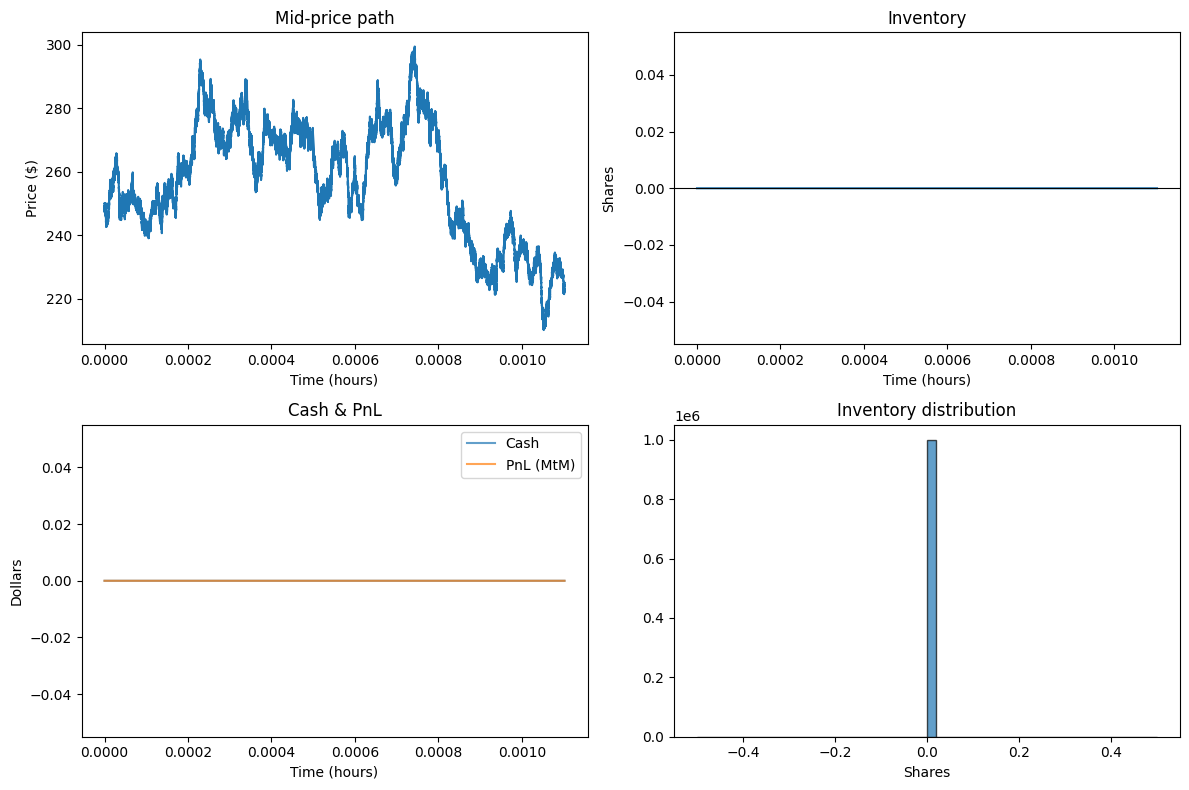

In [ ]:
if __name__ == "__main__":
    np.random.seed(42)

    S0 = 250.0
    dt = 1 / 252 / int(1e3)
    n_steps = int(1e6)

    times = np.arange(n_steps) * dt / 3600  # Convert to hours

    (
        S_path,
        q_path,
        cash_path,
        bid_path,
        ask_path,
        trade_count,
    ) = as_market_maker_simulation(S0=S0, dt=dt, n_steps=n_steps)

    # PRICE PATH
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(times, S_path)
    plt.title("Mid-price path")
    plt.xlabel("Time (hours)")
    plt.ylabel("Price ($)")

    # INVENTORY
    plt.subplot(2, 2, 2)
    plt.plot(times, q_path)
    plt.axhline(0, color="black", lw=0.8)
    plt.title("Inventory")
    plt.xlabel("Time (hours)")
    plt.ylabel("Shares")

    # CASH & MTM P&L
    pnl_path = cash_path + q_path * S_path
    plt.subplot(2, 2, 3)
    plt.plot(times, cash_path, label="Cash", alpha=0.7)
    plt.plot(times, pnl_path, label="PnL (MtM)", alpha=0.7)
    plt.title("Cash & PnL")
    plt.xlabel("Time (hours)")
    plt.ylabel("Dollars")
    plt.legend()

    # INVENTORY HISTOGRAM
    plt.subplot(2, 2, 4)
    plt.hist(q_path, bins=50, alpha=0.7, edgecolor="black")
    plt.title("Inventory distribution")
    plt.xlabel("Shares")

    plt.tight_layout()
    plt.show()